In [ ]:
#@title Import library
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#@title Set Hyperparameters
batch_size = 16 #@param {type:"integer"}
epoch_count = 10 #@param {type:"integer"}
noise_dim = 100 #@param {type:"integer"}
n_class = 10 #@param {type:"integer"}
img_size = 32 #@param {type:"integer"}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title Set all tags
tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [ ]:
#@title CIFAR-10 dataset loading
transform = transforms.Compose([
     transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#@title Build Generator Model for generate random data
def build_generator():
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.label_embed = nn.Embedding(n_class, 50)
            self.fc1 = nn.Sequential(
                nn.Linear(noise_dim + 50, 128 * 8 * 8),
                nn.LeakyReLU(0.2)
            )
            self.conv_blocks = nn.Sequential(
                nn.ConvTranspose2d(128, 128, 4, 2, 1),
                nn.LeakyReLU(0.2),
                nn.ConvTranspose2d(128, 128, 4, 2, 1),
                nn.LeakyReLU(0.2),
                nn.Conv2d(128, 3, 8, padding=3),
                nn.Tanh()
            )

        def forward(self, noise, labels):
            label_input = self.label_embed(labels)
            x = torch.cat((noise, label_input), dim=1)
            x = self.fc1(x).view(-1, 128, 8, 8)
            return self.conv_blocks(x)

    return Generator()

In [ ]:
#@title Build Discriminator Model for Detection what this image is a target or not
def build_discriminator():
    class Discriminator(nn.Module):
        def __init__(self):
            super().__init__()
            self.label_embed = nn.Embedding(n_class, 50)
            self.fc1 = nn.Linear(50, img_size * img_size)
            self.conv = nn.Sequential(
                nn.Conv2d(4, 128, 3, 2, 1),
                nn.LeakyReLU(0.2),
                nn.Conv2d(128, 128, 3, 2, 1),
                nn.LeakyReLU(0.2),
                nn.Flatten(),
                nn.Dropout(0.4),
                nn.Linear(128 * 8 * 8, 1),
                nn.Sigmoid()
            )

        def forward(self, img, labels):
          label_input = self.label_embed(labels)
          label_img = self.fc1(label_input).view(-1, 1, img_size, img_size)

          # Ensure both tensors have the same spatial size
          if img.shape[2:] != label_img.shape[2:]:
              h = min(img.shape[2], label_img.shape[2])
              w = min(img.shape[3], label_img.shape[3])
              img = img[:, :, :h, :w]
              label_img = label_img[:, :, :h, :w]

          x = torch.cat((img, label_img), dim=1)
          return self.conv(x)

    return Discriminator()


In [ ]:
#@title Initialize models
g_model = build_generator().to(device)
d_model = build_discriminator().to(device)

In [ ]:
#@title g_model architecture view
print(g_model)

Generator(
  (label_embed): Embedding(10, 50)
  (fc1): Sequential(
    (0): Linear(in_features=150, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv_blocks): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(128, 3, kernel_size=(8, 8), stride=(1, 1), padding=(3, 3))
    (5): Tanh()
  )
)


In [ ]:
#@title d_model architecture view
print(d_model)

Discriminator(
  (label_embed): Embedding(10, 50)
  (fc1): Linear(in_features=50, out_features=1024, bias=True)
  (conv): Sequential(
    (0): Conv2d(4, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=8192, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [ ]:
#@title Loss and optimizers
criterion = nn.BCELoss()
d_optimizer = optim.Adam(d_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(g_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
#@title Training Model Function Declaration
from tqdm import tqdm

# Training loop with tqdm
def train():
    for epoch in range(epoch_count):
        g_model.train()
        d_model.train()
        d_losses, g_losses = [], []

        # Wrap data loader with tqdm for progress bar
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{epoch_count}", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            batch_size = images.size(0)

            # Train Discriminator
            noise = torch.randn(batch_size, noise_dim).to(device)
            fake_images = g_model(noise, labels)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            d_optimizer.zero_grad()
            real_output = d_model(images, labels)
            fake_output = d_model(fake_images.detach(), labels)
            d_loss = criterion(real_output, real_labels) + criterion(fake_output, fake_labels)
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            fake_output = d_model(fake_images, labels)
            g_loss = criterion(fake_output, real_labels)
            g_loss.backward()
            g_optimizer.step()

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

            # Update tqdm with current loss
            progress_bar.set_postfix({
                "D_loss": f"{d_loss.item():.4f}",
                "G_loss": f"{g_loss.item():.4f}"
            })

        print(f"✅ Epoch {epoch+1}/{epoch_count} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")
        generate_images(3)

In [ ]:
#@title Image generation after each epoch
def generate_images(n):
    g_model.eval()
    fig, axes = plt.subplots(n_class, n, figsize=(n, n_class))
    for label in range(n_class):
        noise = torch.randn(n, noise_dim).to(device)
        labels = torch.full((n,), label, dtype=torch.long).to(device)
        with torch.no_grad():
            fake_images = g_model(noise, labels).cpu()
        for i in range(n):
            img = (fake_images[i] * 0.5 + 0.5).clamp(0, 1)
            axes[label, i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
            axes[label, i].axis('off')
            if i == 0:
                axes[label, i].set_ylabel(tags[label])
    plt.tight_layout()
    plt.show()

✅ Epoch 1/10 | D Loss: 0.0773 | G Loss: 8.0028


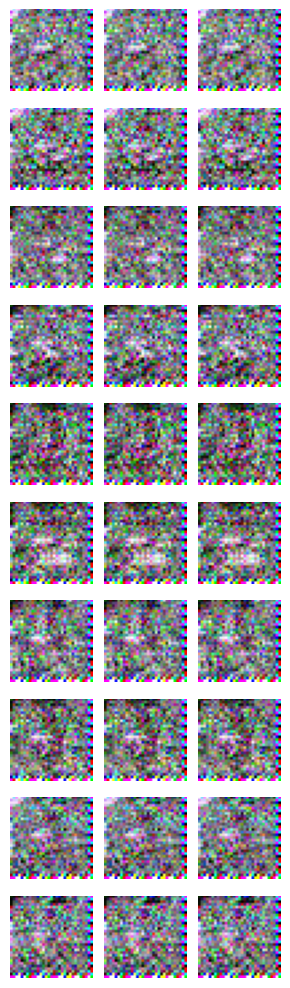

✅ Epoch 2/10 | D Loss: 0.0000 | G Loss: 12.1953


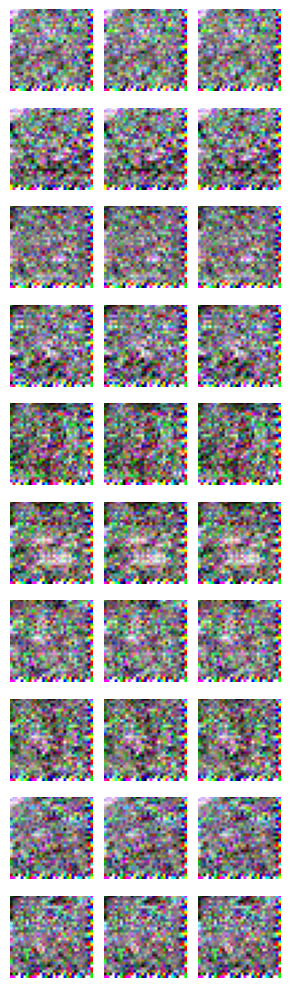

✅ Epoch 3/10 | D Loss: 0.0000 | G Loss: 13.9638


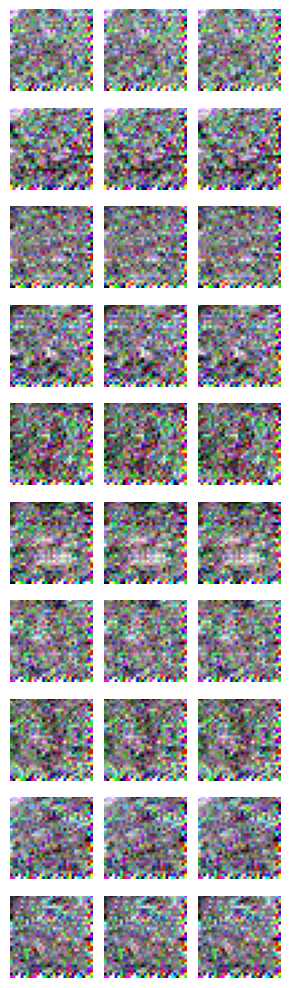

✅ Epoch 4/10 | D Loss: 0.0000 | G Loss: 15.8338


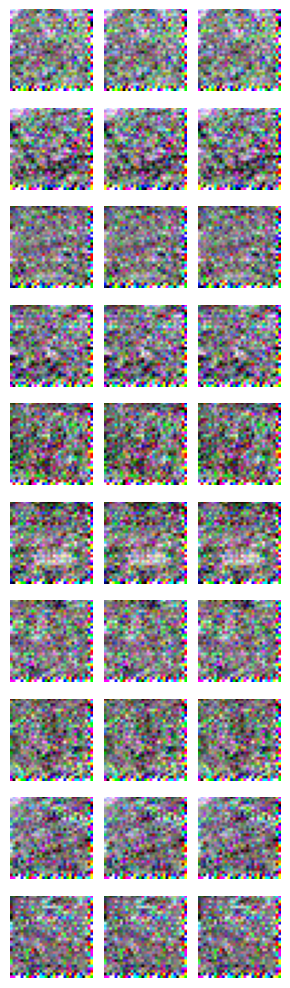

✅ Epoch 5/10 | D Loss: 0.0000 | G Loss: 17.7011


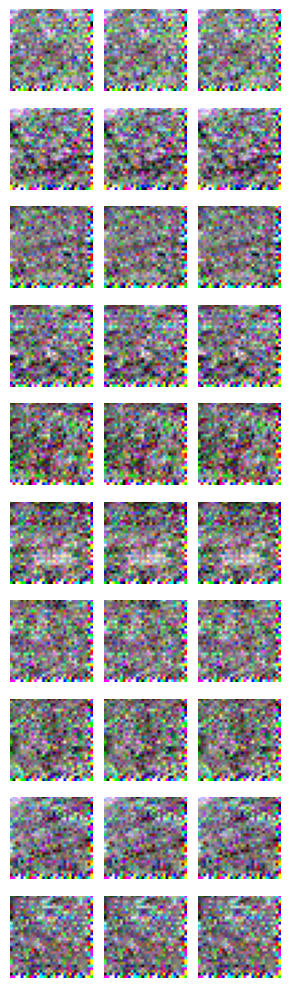

✅ Epoch 6/10 | D Loss: 0.0000 | G Loss: 19.4118


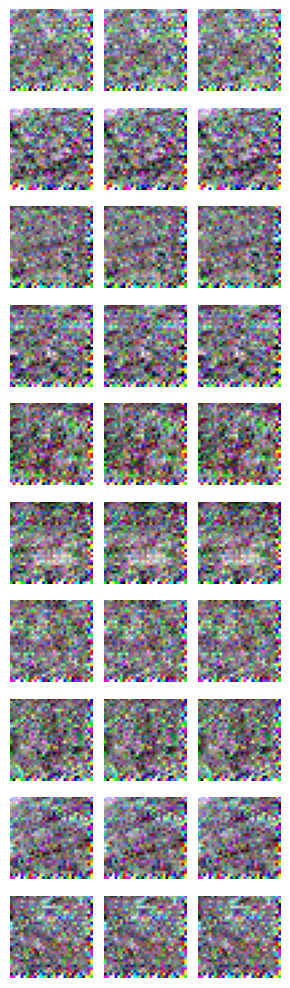

✅ Epoch 7/10 | D Loss: 0.0000 | G Loss: 21.0108


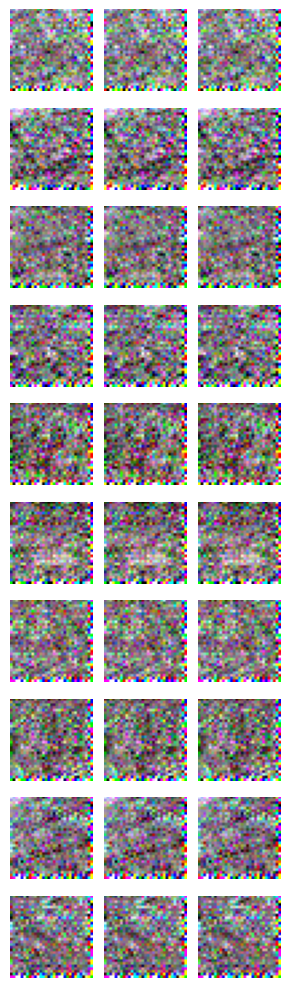

✅ Epoch 8/10 | D Loss: 0.0000 | G Loss: 22.6873


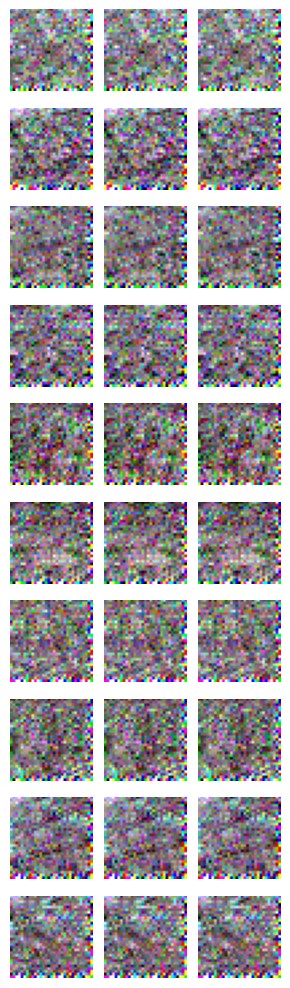

✅ Epoch 9/10 | D Loss: 0.0000 | G Loss: 23.8983


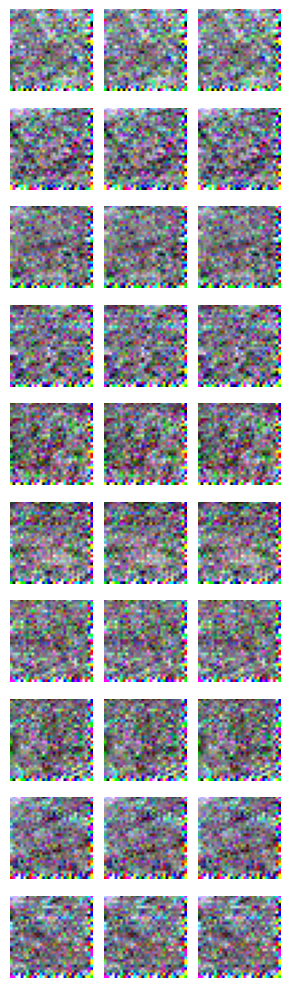

✅ Epoch 10/10 | D Loss: 0.0000 | G Loss: 25.0263


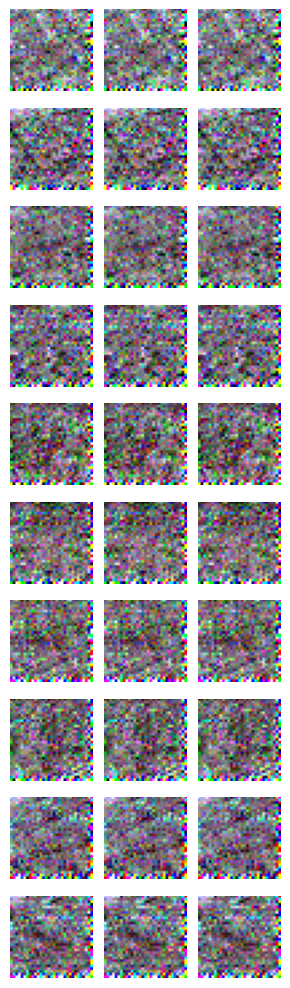

In [ ]:
#@title Start training
train()

In [ ]:
#@title Function to generate and display images for specific class labels
def generate_by_class(target_class=0, num_images=5):
    g_model.eval()  # Set model to evaluation mode

    # Create latent vectors and class labels
    noise = torch.randn(num_images, noise_dim).to(device)
    labels = torch.full((num_images,), target_class, dtype=torch.long).to(device)

    with torch.no_grad():
        generated_images = g_model(noise, labels).cpu()

    # Visualize the generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        img = (generated_images[i] * 0.5 + 0.5).clamp(0, 1)  # Denormalize [-1, 1] → [0, 1]
        np_img = np.transpose(img.numpy(), (1, 2, 0))
        axes[i].imshow(np_img)
        axes[i].axis("off")
    plt.suptitle(f"Generated Images for Class: {tags[target_class]}")
    plt.show()

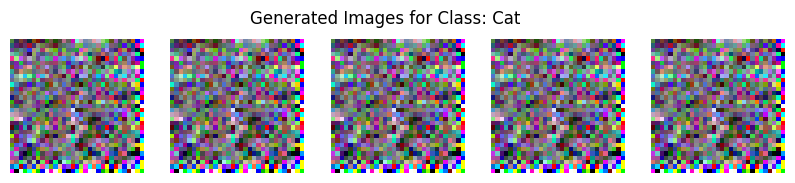

In [ ]:
#@title Example usage
generate_by_class(target_class=3, num_images=5)  # 3 = Cat